# Bank Customer Segmentation and Loan Classification

In this project, I use a comprehensive dataset sourced from a retail bank, consisting of a total of 8 datasets. These datasets are an enhanced variant of the Beka Dataset - the original database was published by Berka (2000). The Beka Database is the financial dataset of a bank in the Czech Republic. It contains data of over 5300 customers with nearly 1,000,000 transactions. Also, the bank granted 700 loans and issued approximately 900 credit cards.

The purpose of this project is to:
- **Customer Segmentation**: Cluster customers into different groups
- **Risk Classification**: Build a Logistics Regression model to predict a risk rating score to each loan.

In [64]:
import pandas as pd
import numpy as np
from duckdb import sql
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

## Data Preparation and Exploration

### 1. Account

In [2]:
df_acct = pd.read_csv('./completedacct.csv')
df_acct

,account_id,district_id,frequency,parseddate,year,month,day
0,A00000576,55,Monthly Issuance,2013-01-01,2013,1,1
1,A00003818,74,Monthly Issuance,2013-01-01,2013,1,1
2,A00000704,55,Monthly Issuance,2013-01-01,2013,1,1
3,A00002378,16,Monthly Issuance,2013-01-01,2013,1,1
4,A00002632,24,Monthly Issuance,2013-01-02,2013,1,2
...,...,...,...,...,...,...,...
4495,A00000124,55,Monthly Issuance,2017-12-28,2017,12,28
4496,A00003958,59,Monthly Issuance,2017-12-28,2017,12,28
4497,A00000777,30,Monthly Issuance,2017-12-28,2017,12,28
4498,A00001573,63,Monthly Issuance,2017-12-29,2017,12,29


In [3]:
df_acct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   object
 1   district_id  4500 non-null   int64 
 2   frequency    4500 non-null   object
 3   parseddate   4500 non-null   object
 4   year         4500 non-null   int64 
 5   month        4500 non-null   int64 
 6   day          4500 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 246.2+ KB


In [4]:
df_acct['frequency'].value_counts()

frequency
Monthly Issuance              4167
Weekly Issuance                240
Issuance After Transaction      93
Name: count, dtype: int64

In [5]:
df_acct['parseddate'] = pd.to_datetime(df_acct['parseddate'])

### 2. Card

In [6]:
df_card = pd.read_csv('./completedcard.csv')
df_card

,card_id,disp_id,type,year,month,day,fulldate
0,V00001005,D00009285,VISA Signature,2013,11,7,2013-11-07
1,V00000104,D00000588,VISA Signature,2014,1,19,2014-01-19
2,V00000747,D00004915,VISA Signature,2014,2,5,2014-02-05
3,V00000070,D00000439,VISA Signature,2014,2,8,2014-02-08
4,V00000577,D00003687,VISA Signature,2014,2,15,2014-02-15
...,...,...,...,...,...,...,...
887,V00000125,D00000694,VISA Infinite,2018,12,26,2018-12-26
888,V00000674,D00004360,VISA Signature,2018,12,28,2018-12-28
889,V00000322,D00002063,VISA Signature,2018,12,28,2018-12-28
890,V00000685,D00004467,VISA Signature,2018,12,29,2018-12-29


In [7]:
df_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   card_id   892 non-null    object
 1   disp_id   892 non-null    object
 2   type      892 non-null    object
 3   year      892 non-null    int64 
 4   month     892 non-null    int64 
 5   day       892 non-null    int64 
 6   fulldate  892 non-null    object
dtypes: int64(3), object(4)
memory usage: 48.9+ KB


In [8]:
df_card['type'].value_counts()

type
VISA Signature    659
VISA Standard     145
VISA Infinite      88
Name: count, dtype: int64

In [9]:
df_card['fulldate'] = pd.to_datetime(df_card['fulldate'])

### 3. Client

In [10]:
df_client = pd.read_csv('./completedclient.csv')
df_client

,client_id,sex,fulldate,day,month,year,age,social,first,middle,last,phone,email,address_1,address_2,city,state,zipcode,district_id
0,C00000001,Female,1990-12-13,13,12,1990,29,926-93-2157,Emma,Avaya,Smith,367-171-6840,emma.smith@gmail.com,387 Wellington Ave.,Unit 1,Albuquerque,NM,47246,18
1,C00000002,Male,1965-02-04,4,2,1965,54,806-94-5725,Noah,Everest,Thompson,212-423-7734,noah.thompson@gmail.com,75 W. Berkshire St.,NaN,New York City,NY,10040,1
2,C00000003,Female,1960-10-09,9,10,1960,59,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,olivia.johnson@outlook.com,36 Second St.,NaN,New York City,NY,10162,1
3,C00000004,Male,1976-12-01,1,12,1976,43,580-20-3414,Liam,Irvin,White,951-567-8925,liam.white@gmail.com,7607 Sunnyslope Street,NaN,Indianapolis,IN,49047,5
4,C00000005,Female,1980-07-03,3,7,1980,39,536-14-5809,Sophia,Danae,Williams,428-265-1568,sophia.williams@gmail.com,755 Galvin Street,NaN,Indianapolis,IN,40852,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364,C00013955,Female,1965-10-30,30,10,1965,54,830-38-3530,Adrianna,Jillian,Moore,212-205-7422,adrianna.moore@outlook.com,9405 SW. Leeton Ridge Drive,NaN,New York City,NY,10121,1
5365,C00013956,Male,1963-04-06,6,4,1963,56,773-25-4409,Aaron,Roman,Park,212-645-8820,aaron.park@gmail.com,7021 Chapel Ave.,NaN,New York City,NY,10118,1
5366,C00013968,Male,1988-04-13,13,4,1988,31,227-17-0778,Eli,Leonardo,Warner,508-465-5164,eli.warner@hotmail.com,43 Edgemont Dr.,NaN,Fall River,MA,2721,61
5367,C00013971,Female,1982-10-19,19,10,1982,37,278-77-3298,Ruth,Joy,Martin,856-636-3840,ruth.martin@gmail.com,7087 E. Pennsylvania Street,Unit 8,Danbury,CT,48475,67


In [11]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   client_id    5369 non-null   object
 1   sex          5369 non-null   object
 2   fulldate     5369 non-null   object
 3   day          5369 non-null   int64 
 4   month        5369 non-null   int64 
 5   year         5369 non-null   int64 
 6   age          5369 non-null   int64 
 7   social       5369 non-null   object
 8   first        5369 non-null   object
 9   middle       5369 non-null   object
 10  last         5369 non-null   object
 11  phone        5369 non-null   object
 12  email        5369 non-null   object
 13  address_1    5369 non-null   object
 14  address_2    83 non-null     object
 15  city         5369 non-null   object
 16  state        5369 non-null   object
 17  zipcode      5369 non-null   int64 
 18  district_id  5369 non-null   int64 
dtypes: int64(6), object(13)
mem

### 4. Disposition

In [12]:
df_disposition = pd.read_csv('./completeddisposition.csv')
df_disposition

,disp_id,client_id,account_id,type
0,D00000001,C00000001,A00000001,Owner
1,D00000002,C00000002,A00000002,Owner
2,D00000003,C00000003,A00000002,User
3,D00000004,C00000004,A00000003,Owner
4,D00000005,C00000005,A00000003,User
...,...,...,...,...
5364,D00013647,C00013955,A00011349,Owner
5365,D00013648,C00013956,A00011349,User
5366,D00013660,C00013968,A00011359,Owner
5367,D00013663,C00013971,A00011362,Owner


### 5. District

In [13]:
df_district = pd.read_csv('./completeddistrict.csv')
df_district

,district_id,city,state_name,state_abbrev,region,division
0,1,New York City,New York,NY,Northeast,Middle Atlantic
1,2,Jacksonville,Florida,FL,South,South Atlantic
2,3,Columbus,Ohio,OH,Midwest,East North Central
3,4,Charlotte,North Carolina,NC,South,South Atlantic
4,5,Indianapolis,Indiana,IN,Northeast,East North Central
...,...,...,...,...,...,...
72,73,New Britain,Connecticut,CT,Northeast,New England
73,74,Chicago,Illinois,IL,Northeast,East North Central
74,75,Rochester,New York,NY,Northeast,Middle Atlantic
75,76,Yonkers,New York,NY,Northeast,Middle Atlantic


### 6. Loan

In [14]:
df_loan = pd.read_csv('./completedloan.csv')
df_loan

,loan_id,account_id,amount,duration,payments,status,year,month,day,fulldate,location,purpose
0,L00005657,A00003354,4980,12,415,A,2014,7,5,2014-07-05,59,car
1,L00006234,A00006061,5148,12,429,C,2018,5,28,2018-05-28,1,car
2,L00006699,A00008330,7656,24,319,A,2014,3,30,2014-03-30,1,car
3,L00006688,A00008268,8616,24,359,C,2017,9,26,2017-09-26,1,car
4,L00006312,A00006453,10944,36,304,C,2018,5,17,2018-05-17,1,car
...,...,...,...,...,...,...,...,...,...,...,...,...
677,L00005569,A00002936,504000,60,8400,C,2018,1,20,2018-01-20,18,home
678,L00005132,A00000817,538500,60,8975,C,2015,2,17,2015-02-17,64,home
679,L00005447,A00002335,541200,60,9020,D,2017,11,12,2017-11-12,59,home
680,L00006791,A00008926,566640,60,9444,C,2018,1,23,2018-01-23,1,home


In [15]:
df_loan.columns

Index(['loan_id', 'account_id', 'amount', 'duration', 'payments', 'status',
       'year', 'month', 'day', 'fulldate', 'location', 'purpose'],
      dtype='object')

In [16]:
df_loan['fulldate'] = pd.to_datetime(df_loan['fulldate'])

### 7. Order

In [17]:
df_order = pd.read_csv('./completedorder.csv')
df_order

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,A00000001,YZ,87144583,2452.0,Household Payment
1,29402,A00000002,ST,89597016,3372.7,Loan Payment
2,29403,A00000002,QR,13943797,7266.0,Household Payment
3,29404,A00000003,WX,83084338,1135.0,Household Payment
4,29405,A00000003,CD,24485939,327.0,
...,...,...,...,...,...,...
6466,46334,A00011362,YZ,70641225,4780.0,Household Payment
6467,46335,A00011362,MN,78507822,56.0,
6468,46336,A00011362,ST,40799850,330.0,Insurance Payment
6469,46337,A00011362,KL,20009470,129.0,


### 8. Transaction

In [18]:
df_trans = pd.read_csv('./completedtrans.csv')
df_trans

,Unnamed: 0,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime
0,1,T00695247,A00002378,Credit,Credit in Cash,700.0,700.0,NaN,NaN,NaN,2013,1,1,2013-01-01,11:02:40,2013-01-01T11:02:40
1,2,T00171812,A00000576,Credit,Credit in Cash,900.0,900.0,NaN,NaN,NaN,2013,1,1,2013-01-01,08:23:33,2013-01-01T08:23:33
2,3,T00207264,A00000704,Credit,Credit in Cash,1000.0,1000.0,NaN,NaN,NaN,2013,1,1,2013-01-01,15:19:21,2013-01-01T15:19:21
3,4,T01117247,A00003818,Credit,Credit in Cash,600.0,600.0,NaN,NaN,NaN,2013,1,1,2013-01-01,10:42:35,2013-01-01T10:42:35
4,5,T00579373,A00001972,Credit,Credit in Cash,400.0,400.0,NaN,NaN,NaN,2013,1,2,2013-01-02,11:39:25,2013-01-02T11:39:25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056315,1056316,T03626622,A00002906,Credit,NaN,62.3,13729.4,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,15:18:14,2018-12-31T15:18:14
1056316,1056317,T03627616,A00002935,Credit,NaN,81.3,19544.9,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,13:04:60,2018-12-31T13:04:60
1056317,1056318,T03625403,A00002869,Credit,NaN,60.2,14638.2,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,08:30:13,2018-12-31T08:30:13
1056318,1056319,T03626683,A00002907,Credit,NaN,107.5,23453.0,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,14:45:19,2018-12-31T14:45:19


In [19]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Unnamed: 0        1056320 non-null  int64  
 1   trans_id          1056320 non-null  object 
 2   account_id        1056320 non-null  object 
 3   type              1056320 non-null  object 
 4   operation         873206 non-null   object 
 5   amount            1056320 non-null  float64
 6   balance           1056320 non-null  float64
 7   k_symbol          574439 non-null   object 
 8   bank              273508 non-null   object 
 9   account           295389 non-null   float64
 10  year              1056320 non-null  int64  
 11  month             1056320 non-null  int64  
 12  day               1056320 non-null  int64  
 13  fulldate          1056320 non-null  object 
 14  fulltime          1056320 non-null  object 
 15  fulldatewithtime  1056320 non-null  object 
dtype

In [20]:
df_trans.iloc[:,8].value_counts()

bank
TD Bank                          22285
JPMorgan Chase                   21720
Capital One                      21711
State Street Corp.               21582
Wells Fargo & Co.                21499
Citigroup                        21293
Morgan Stanley                   21234
Bank of New York Mellon Corp.    21167
PNC Financial Services           21094
Goldman Sachs                    20525
Charles Schwab Corp.             20178
U.S. Bancorp                     19623
Bank of America                  19597
Name: count, dtype: int64

In [21]:
df_trans[df_trans['account_id'] == 'A00002378']

,Unnamed: 0,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime
0,1,T00695247,A00002378,Credit,Credit in Cash,700.0,700.0,NaN,NaN,NaN,2013,1,1,2013-01-01,11:02:40,2013-01-01T11:02:40
95,96,T00695250,A00002378,Credit,Credit in Cash,7268.0,7968.0,NaN,NaN,NaN,2013,1,22,2013-01-22,14:43:54,2013-01-22T14:43:54
100,101,T00695266,A00002378,Credit,Credit in Cash,14440.0,22408.0,NaN,NaN,NaN,2013,1,23,2013-01-23,13:56:58,2013-01-23T13:56:58
104,105,T00695262,A00002378,Credit,Credit in Cash,49752.0,72160.0,NaN,NaN,NaN,2013,1,24,2013-01-24,08:37:03,2013-01-24T08:37:03
113,114,T00695265,A00002378,Credit,Credit in Cash,21899.0,94059.0,NaN,NaN,NaN,2013,1,26,2013-01-26,09:50:04,2013-01-26T09:50:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032771,1032772,T00695647,A00002378,Credit,Credit in Cash,1900.0,39664.4,NaN,NaN,NaN,2018,12,1,2018-12-01,09:06:42,2018-12-01T09:06:42
1036812,1036813,T00695410,A00002378,Debit,Remittance to Another Bank,9612.0,30052.4,Household,Citigroup,1222903.0,2018,12,7,2018-12-07,08:13:06,2018-12-07T08:13:06
1049182,1049183,T00695335,A00002378,Credit,Credit in Cash,45410.0,93133.4,NaN,NaN,NaN,2018,12,21,2018-12-21,10:10:52,2018-12-21T10:10:52
1049183,1049184,T00695328,A00002378,Credit,Credit in Cash,17671.0,47723.4,NaN,NaN,NaN,2018,12,21,2018-12-21,16:14:26,2018-12-21T16:14:26


In [22]:
df_trans['k_symbol'].value_counts()

k_symbol
Interest Credited       183114
Payment on Statement    155832
Household               118065
                         53433
Old Age Pension          30338
Insurance Payment        18500
Loan Payment             13580
Sanction Interest         1577
Name: count, dtype: int64

In [23]:
df_trans['fulldate'] = pd.to_datetime(df_trans['fulldate'])

## Feature Engineering

**Merge relevant attributes with client information:**
1. loan: amount, duration, payments, status, fulldate, purpose
2. order: amount_to, amount, k_symbol
3. transaction: type, operation, amount, balance

In [24]:
df_cus = sql("""
select a.client_id, b.sex, b.age, d.amount loan_amount, d.duration loan_duration, 
d.payments loan_payments, d.status loan_status, d.fulldate loan_date, d.purpose loan_purpose,
e.bank_to order_to_bank, e.amount order_amount, e.k_symbol order_purpose, 
f.type trans_type, f.operation trans_operation, f.balance acct_balance, f.fulldate trans_date
from df_disposition a
left join df_client b
on a.client_id = b.client_id
left join df_loan d
on a.account_id = d.account_id
left join df_order e
on a.account_id = e.account_id
left join df_trans f
on a.account_id = f.account_id
""").df()

In [25]:
df_cus[['loan_amount','loan_payments','loan_duration']] = df_cus[['loan_amount','loan_payments','loan_duration']].fillna(0)

In [26]:
# Numerical features
data = sql("""
select client_id, sex, age,
avg(loan_amount) avg_loan_amount, sum(loan_amount) sum_loan_amount, 
min(loan_amount) min_loan_amount, max(loan_amount) max_loan_amount,
avg(loan_payments) avg_loan_payments, sum(loan_payments) sum_loan_payments,
min(loan_payments) min_loan_payments, max(loan_payments) max_loan_payments,
avg(loan_duration) avg_loan_duration, sum(loan_duration) sum_loan_duration, 
min(loan_duration) min_loan_duration, max(loan_duration) max_loan_duration,
avg(order_amount) avg_order_amount, sum(order_amount) sum_order_amount, 
min(order_amount) min_order_amount, max(order_amount) max_order_amount,
avg(acct_balance) avg_acct_balance, sum(acct_balance) sum_acct_balance, 
min(acct_balance) min_acct_balance, max(acct_balance) max_acct_balance
from df_cus
group by client_id, sex, age
""").df()

In [27]:
data

,client_id,sex,age,avg_loan_amount,sum_loan_amount,min_loan_amount,max_loan_amount,avg_loan_payments,sum_loan_payments,min_loan_payments,...,min_loan_duration,max_loan_duration,avg_order_amount,sum_order_amount,min_order_amount,max_order_amount,avg_acct_balance,sum_acct_balance,min_acct_balance,max_acct_balance
0,C00002345,Male,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2074.333333,2800350.0,23.0,4898.0,22518.046667,30399363.0,1100.0,42606.5
1,C00005441,Male,43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2373.000000,1699068.0,798.0,3948.0,25874.544413,18526173.8,600.0,44316.4
2,C00003734,Male,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,644.333333,755803.0,395.0,845.0,17448.467008,20467051.8,600.0,26254.7
3,C00004937,Female,39,41856.0,42693120.0,41856.0,41856.0,872.0,889440.0,872.0,...,48.0,48.0,1124.750000,1147245.0,403.0,1926.0,41713.700392,42547974.4,800.0,73519.1
4,C00004479,Female,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1058.250000,2082636.0,77.0,3217.0,55755.139431,109726114.4,800.0,152089.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364,C00001235,Female,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,17496.666667,524900.0,400.0,24200.0
5365,C00002705,Male,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2028.000000,338676.0,2028.0,2028.0,22669.375449,3785785.7,400.0,44378.3
5366,C00004024,Male,35,19248.0,6313344.0,19248.0,19248.0,1604.0,526112.0,1604.0,...,12.0,12.0,5426.500000,1779892.0,1604.0,9249.0,36320.464634,11913112.4,200.0,65132.4
5367,C00001591,Female,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,660.666667,285408.0,233.0,1130.0,15964.513194,6896669.7,300.0,20753.9


In [28]:
# Categorical features
def most_common(feature):
    feature = feature.strip('"\'')
    
    # Use double quotes for the column alias
    most_common_data = sql(f"""
    with temp as (
        select client_id, {feature}, count(*) as {feature}_count
        from df_cus
        group by client_id, {feature}
    )
    select distinct on (client_id) client_id, {feature} as most_common_{feature}
    from temp
    order by client_id, {feature}_count desc
    """).df()
    
    return most_common_data

In [29]:
cat_lst = ['loan_purpose', 'loan_status', 'order_purpose','trans_type','trans_operation']
cat_data = pd.DataFrame()
# Iterate through the categorical features
for feature in cat_lst:
    # Run the most_common function for the current feature
    most_common_data = most_common(feature)
    # Remove the 'client_id' column if it's not the first DataFrame
    if 'client_id' in most_common_data.columns and 'client_id' in cat_data.columns:
        most_common_data = most_common_data.drop(columns='client_id')
     # Append the most_common_data to the cat_data DataFrame
    cat_data = pd.concat([cat_data, most_common_data], axis=1)

In [30]:
cat_data

,client_id,most_common_loan_purpose,most_common_loan_status,most_common_order_purpose,most_common_trans_type,most_common_trans_operation
0,C00000001,None,None,Household Payment,Debit,Cash Withdrawal
1,C00000002,home,A,Household Payment,Debit,Cash Withdrawal
2,C00000003,home,A,Loan Payment,Debit,Cash Withdrawal
3,C00000004,None,None,Household Payment,Debit,Remittance to Another Bank
4,C00000005,None,None,,Debit,Remittance to Another Bank
...,...,...,...,...,...,...
5364,C00013955,home,C,Loan Payment,Debit,Cash Withdrawal
5365,C00013956,home,C,Household Payment,Debit,Cash Withdrawal
5366,C00013968,home,A,Household Payment,Debit,Cash Withdrawal
5367,C00013971,home,A,,Debit,Remittance to Another Bank


In [31]:
data_final = sql("""
select a.*, b.* exclude(client_id) from data a
left join cat_data b
on a.client_id = b.client_id
""").df()
data_final

,client_id,sex,age,avg_loan_amount,sum_loan_amount,min_loan_amount,max_loan_amount,avg_loan_payments,sum_loan_payments,min_loan_payments,...,max_order_amount,avg_acct_balance,sum_acct_balance,min_acct_balance,max_acct_balance,most_common_loan_purpose,most_common_loan_status,most_common_order_purpose,most_common_trans_type,most_common_trans_operation
0,C00002345,Male,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4898.0,22518.046667,30399363.0,1100.0,42606.5,None,None,Household Payment,Debit,Remittance to Another Bank
1,C00003734,Male,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,845.0,17448.467008,20467051.8,600.0,26254.7,None,None,Household Payment,Debit,Remittance to Another Bank
2,C00004937,Female,39,41856.0,42693120.0,41856.0,41856.0,872.0,889440.0,872.0,...,1926.0,41713.700392,42547974.4,800.0,73519.1,debt_consolidation,C,Household Payment,Debit,Remittance to Another Bank
3,C00004113,Female,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4324.0,67224.483158,76635910.8,400.0,162808.9,None,None,Household Payment,Debit,Cash Withdrawal
4,C00009202,Male,37,30276.0,33182496.0,30276.0,30276.0,2523.0,2765208.0,2523.0,...,6817.0,53878.874453,59051246.4,900.0,130361.7,debt_consolidation,A,Loan Payment,Debit,Cash Withdrawal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364,C00002996,Male,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,17000.000000,663000.0,1100.0,29100.0,None,None,None,Credit,Credit in Cash
5365,C00001671,Female,68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2705.0,18330.624390,5260889.2,1000.0,28998.6,None,None,Household Payment,Debit,Cash Withdrawal
5366,C00000365,Male,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1628.0,36365.451491,13418851.6,400.0,76941.7,None,None,Household Payment,Debit,Cash Withdrawal
5367,C00001341,Female,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3637.0,25068.146366,20004380.8,200.0,46241.4,None,None,,Debit,Cash Withdrawal


In [32]:
data_final.columns

Index(['client_id', 'sex', 'age', 'avg_loan_amount', 'sum_loan_amount',
       'min_loan_amount', 'max_loan_amount', 'avg_loan_payments',
       'sum_loan_payments', 'min_loan_payments', 'max_loan_payments',
       'avg_loan_duration', 'sum_loan_duration', 'min_loan_duration',
       'max_loan_duration', 'avg_order_amount', 'sum_order_amount',
       'min_order_amount', 'max_order_amount', 'avg_acct_balance',
       'sum_acct_balance', 'min_acct_balance', 'max_acct_balance',
       'most_common_loan_purpose', 'most_common_loan_status',
       'most_common_order_purpose', 'most_common_trans_type',
       'most_common_trans_operation'],
      dtype='object')

## Customer Segmentation

In [33]:
le = preprocessing.LabelEncoder()
ds = data_final.apply(le.fit_transform)
ds.head()

,client_id,sex,age,avg_loan_amount,sum_loan_amount,min_loan_amount,max_loan_amount,avg_loan_payments,sum_loan_payments,min_loan_payments,...,max_order_amount,avg_acct_balance,sum_acct_balance,min_acct_balance,max_acct_balance,most_common_loan_purpose,most_common_loan_status,most_common_order_purpose,most_common_trans_type,most_common_trans_operation
0,2219,1,45,0,0,0,0,0,0,0,...,1763,1058,4102,318,1240,4,4,1,1,3
1,3534,1,44,0,0,0,0,0,0,0,...,15,353,3668,307,296,4,4,1,1,3
2,4593,0,27,84,273,84,84,30,168,30,...,357,3049,4355,311,2595,1,2,1,1,3
3,3892,0,40,0,0,0,0,0,0,0,...,1559,4614,4658,299,4412,4,4,1,1,0
4,4990,1,25,55,218,55,55,163,460,163,...,2299,3991,4568,313,3898,1,0,4,1,0


In [34]:
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['client_id']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [35]:
#Initiating PCA to reduce dimentions to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=['col1','col2','col3'])
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,5369.0,2.223341e-16,3.538494,-2.419261,-1.762314,-1.236638,-0.819688,14.169283
col2,5369.0,-1.482227e-16,2.070271,-4.518565,-1.692938,-0.290232,1.424150,5.211624
col3,5369.0,6.881770e-17,1.498215,-4.366515,-1.084603,0.128659,1.114271,6.227563


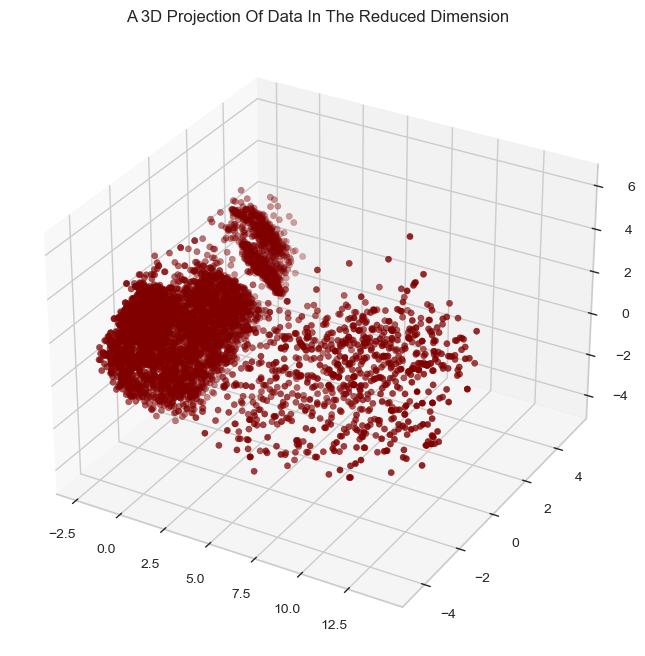

In [36]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

Elbow Method to determine the number of clusters to be formed:


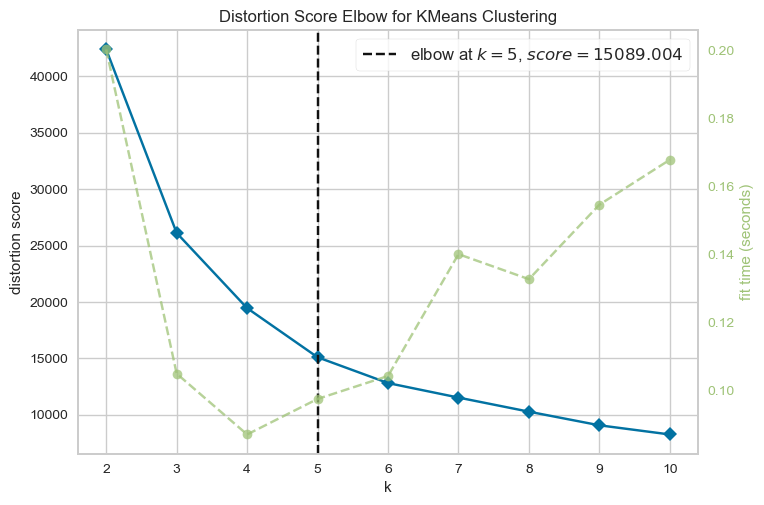

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [37]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans())
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [38]:
#Initiating the KMeans Clustering model 
KM = KMeans(n_clusters=5)
# fit model and predict clusters
yhat_KM = KM.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_KM
#Adding the Clusters feature to the orignal dataframe.
data_final["Clusters"]= yhat_KM

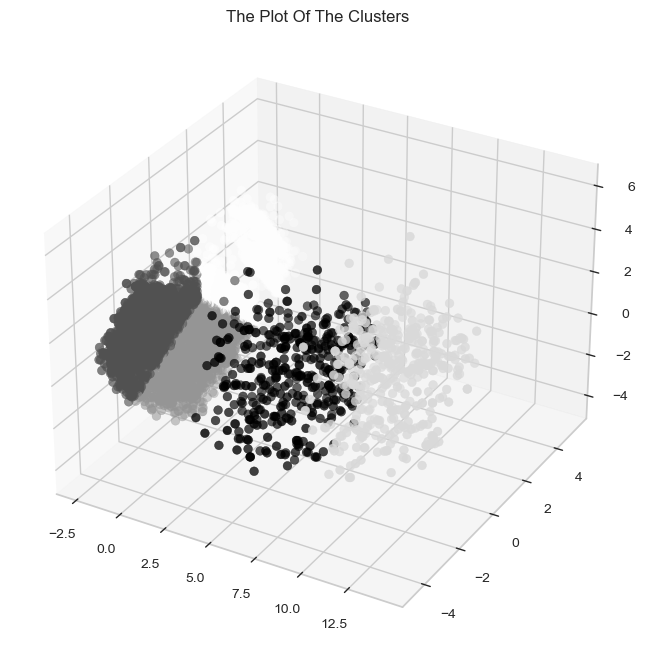

In [39]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o')
ax.set_title("The Plot Of The Clusters")
plt.show()

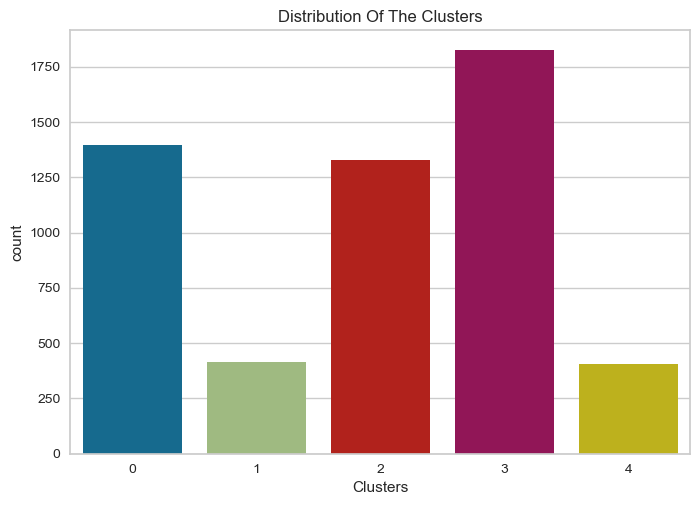

In [40]:
# Plotting countplot of clusters
pl = sns.countplot(x=data_final["Clusters"])
pl.set_title("Distribution Of The Clusters")
plt.show()

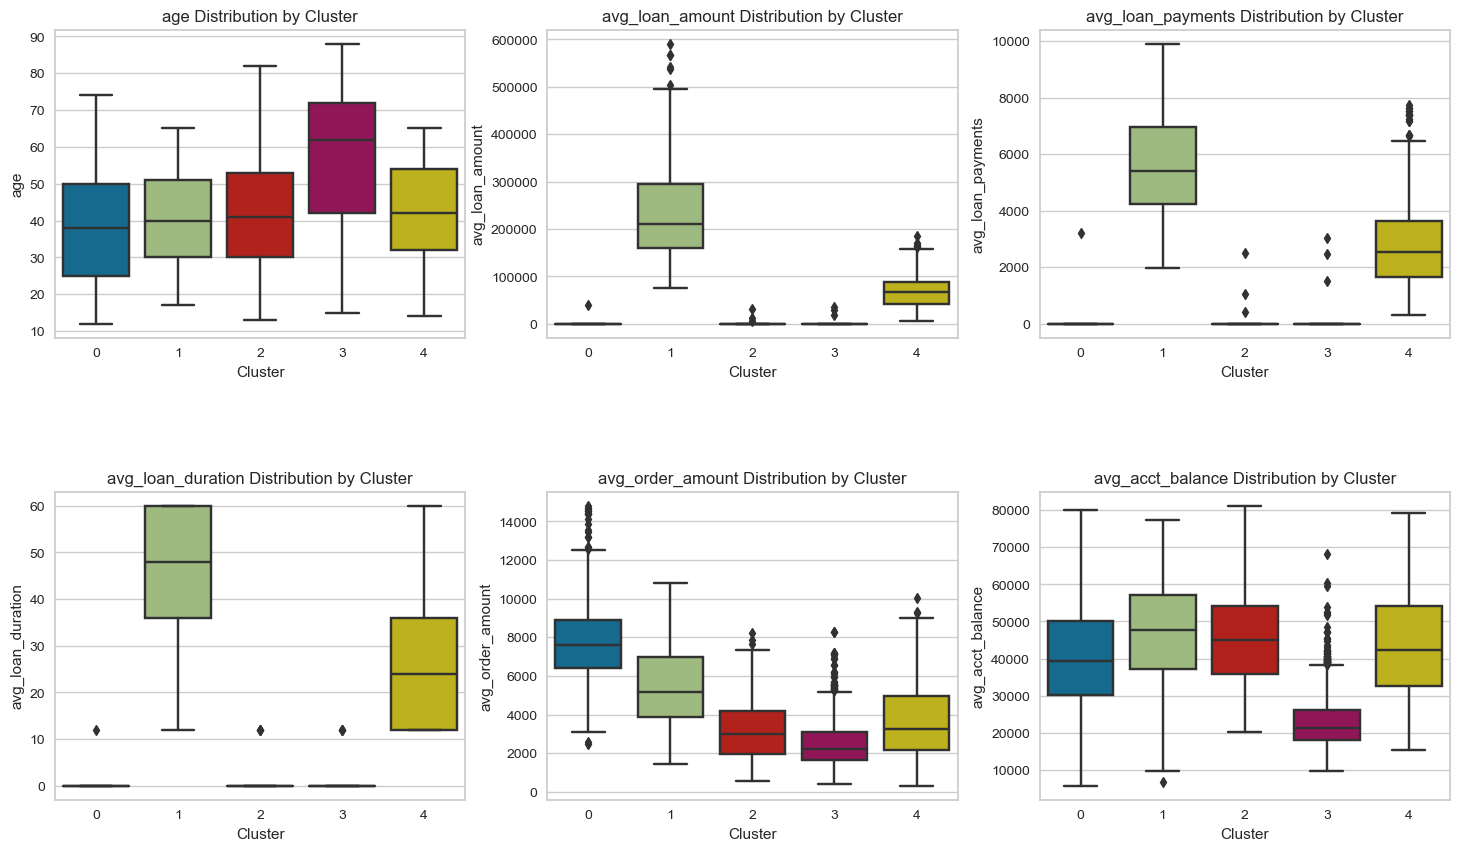

In [41]:
# Features to display
num_features = ['age', 'avg_loan_amount', 'avg_loan_payments', 'avg_loan_duration', 'avg_order_amount', 'avg_acct_balance']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
plt.subplots_adjust(hspace=0.5)  # Adjust the spacing between subplots

# Iterate through features and create box plots
for i, num_feature in enumerate(num_features):
    row = i // 3
    col = i % 3
    sns.boxplot(x='Clusters', y=num_feature, data=data_final, ax=axes[row, col])
    axes[row, col].set_title(f'{num_feature} Distribution by Cluster')
    axes[row, col].set_xlabel('Cluster')
    axes[row, col].set_ylabel(num_feature)

plt.show()

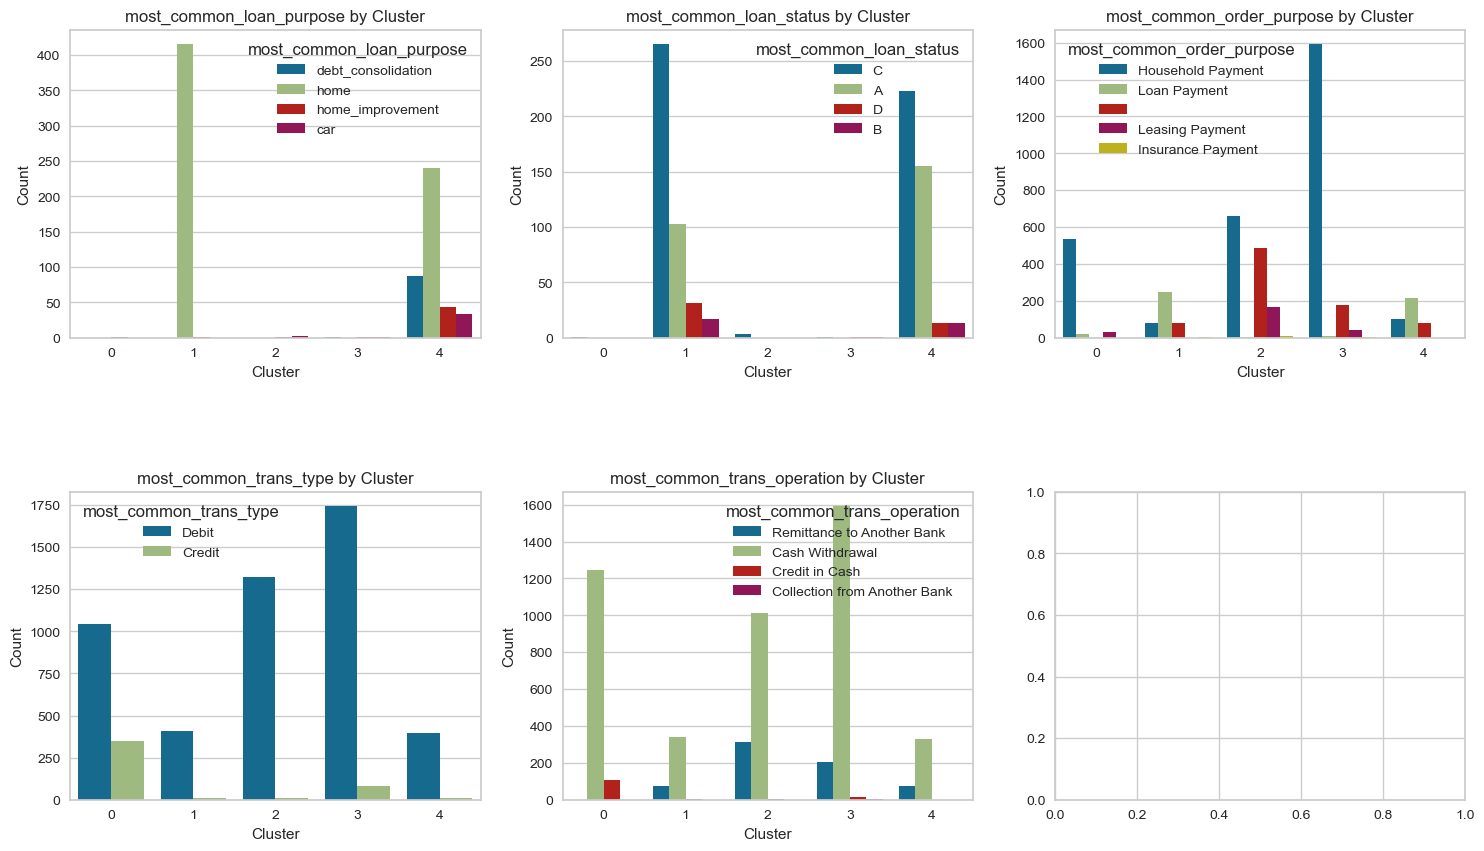

In [42]:
# Features to display
cat_features = ['most_common_loan_purpose', 'most_common_loan_status','most_common_order_purpose', 'most_common_trans_type','most_common_trans_operation']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
plt.subplots_adjust(hspace=0.5)  # Adjust the spacing between subplots

# Iterate through categorical features and create count plots
for i, cat_feature in enumerate(cat_features):
    row = i // 3
    col = i % 3
    sns.countplot(x='Clusters', hue=cat_feature, data=data_final, ax=axes[row, col])
    axes[row, col].set_title(f'{cat_feature} by Cluster')
    axes[row, col].set_xlabel('Cluster')
    axes[row, col].set_ylabel('Count')

plt.show()

**Raw interpretation**: 
1. Cluster 0: Few loans, mid-career and late-career, average loan payment of lower end (2000 to 4000) with medium-term loan, uses loan for the diverse purposes.
3. Cluster 1: No loan, early-career and mid-career, highest average order amount, the only cluster uses credit in cash
5. Cluster 2: No loan, late-career, smallest order amount and smallest average account balance.
6. Cluster 3: Most loans, mid-career and late-career, high average loan amount with the most loan payments, pretty high average account balance. these people all in debt for housing purpose.
7. Cluster 4: Very few loan, mid-career and late-career, average order amount monstly ranging from 3000 to over 6000, usually for household payment, average account balance monstly ranging from over 30000 to over 50000.

**Insights**:
1. **Cluster 0 (Moderate Loan Users with Diverse Needs)**:
* Customers in this cluster have a moderate number of loans, but not too many.
* They are typically in their mid-career and late-career stages, similar to Cluster 0.
* Their average loan payments fall on the lower end, ranging from 2000 to 4000, and they tend to take out medium-term loans.
* These customers use loans for various purposes, indicating diverse financial needs or opportunities.
  
2. **Cluster 1 (Early and Mid-Career Cash Credit Users)**:
* These customers do not have any outstanding loans.
* They are typically in their early-career and mid-career stages.
* They have the highest average order amounts among all clusters, indicating higher spending.
* This is the only cluster that uses credit for cash transactions, suggesting they might use credit for immediate cash needs or convenience.

3. **Cluster 2 (Late-Career Savers with Minimal Activity)**:
* Customers in this cluster do not have any outstanding loans.
* They are in the late-career stage of life.
* They have the smallest order amounts and the lowest average account balance among all clusters, suggesting they may not have significant spending or may have already spent their savings.

4. **Cluster 3 (Heavy Mortgage Borrowers with High Savings)**:
* Customers in this cluster have the most loans, particularly housing loans.
* They are in their mid-career and late-career stages.
* They have high average loan amounts and make the most loan payments, indicating significant debt, likely due to housing loans.
* Despite the high debt, their average account balance remains pretty high, suggesting they may be handling their housing debt well and continue to save.

5. **Cluster 4 (Mid-Career and Late-Career Savers)**:
* These customers do not have any outstanding loans.
* They are typically in their mid-career and late-career stages, suggesting they may be planning for retirement or already retired.
* They make average order amounts, primarily in the range of 3000 to over 6000, often for household payments.
* Their average account balance is relatively high, ranging from over 30,000 to over 50,000. This suggests they have substantial savings or investments.

## Risk Classification

In [43]:
df_cus['loan_status'].value_counts()

loan_status
C    262071
A    249908
B     20151
D     19887
Name: count, dtype: int64

There are 2 types of loan contracts recorded in this dataset:
* **Finished contracts**:
* * A loan ranked A means it is paid in full and on time with no problem
  * A loan ranked B means the loan is not paid, meaning it went default.
* **Running contracts**:
* * A loan ranked C means the paying process has been going well
* * A loan ranked rank D means the loan may not be paid since the client is in debt.

### Univariate Analysis

In [44]:
loan_data = sql("""
select loan_id, account_id, amount, duration, payments, purpose, status
from df_loan
""")
loan_cus_data = sql("""
select a.* exclude(account_id), b.client_id, c.* exclude(client_id)
from loan_data a
left join df_disposition b
on a.account_id = b.account_id
left join data_final c
on b.client_id = c.client_id
""").df()
loan_cus_data = loan_cus_data.dropna(subset = 'loan_id')

In [45]:
loan_cus_data

,loan_id,amount,duration,payments,purpose,status,client_id,sex,age,avg_loan_amount,...,avg_acct_balance,sum_acct_balance,min_acct_balance,max_acct_balance,most_common_loan_purpose,most_common_loan_status,most_common_order_purpose,most_common_trans_type,most_common_trans_operation,Clusters
0,L00004959,80952,24,3373,home,A,C00000002,Male,54,80952.0,...,36540.704393,34932913.4,1100.0,69302.0,home,A,Household Payment,Debit,Cash Withdrawal,4
1,L00004959,80952,24,3373,home,A,C00000003,Female,59,80952.0,...,36540.704393,34932913.4,1100.0,69302.0,home,A,Loan Payment,Debit,Cash Withdrawal,4
2,L00004961,30276,12,2523,debt_consolidation,B,C00000025,Female,60,30276.0,...,16253.069967,4924680.2,-10604.7,58157.5,debt_consolidation,B,Loan Payment,Credit,Cash Withdrawal,4
3,L00004962,30276,12,2523,debt_consolidation,A,C00000031,Male,37,30276.0,...,56279.128467,61681924.8,900.0,134209.9,debt_consolidation,A,,Debit,Cash Withdrawal,4
4,L00004967,318480,60,5308,home,D,C00000045,Male,47,318480.0,...,37547.422308,19524659.6,-1011.2,104761.5,home,D,,Debit,Cash Withdrawal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,L00005282,388512,48,8094,home,D,C00001917,Female,30,388512.0,...,38211.250147,12953613.8,-2838.8,137263.4,home,D,Loan Payment,Debit,Cash Withdrawal,1
823,L00005316,165960,36,4610,home,A,C00002181,Male,31,165960.0,...,43499.768562,110141414.0,700.0,148809.0,home,A,Loan Payment,Debit,Remittance to Another Bank,1
824,L00005451,159744,48,3328,home,C,C00002841,Female,26,159744.0,...,51807.722613,30929210.4,600.0,115356.1,home,C,Loan Payment,Debit,Cash Withdrawal,1
825,L00005585,88608,12,7384,home,C,C00003609,Female,44,88608.0,...,54237.568452,9111911.5,900.0,148386.3,home,C,Loan Payment,Debit,Cash Withdrawal,4


#### 1. Binning data

In [46]:
num_features = loan_cus_data.select_dtypes(include=['int64', 'float64']).columns.difference(['Clusters'])
num_features

Index(['age', 'amount', 'avg_acct_balance', 'avg_loan_amount',
       'avg_loan_duration', 'avg_loan_payments', 'avg_order_amount',
       'duration', 'max_acct_balance', 'max_loan_amount', 'max_loan_duration',
       'max_loan_payments', 'max_order_amount', 'min_acct_balance',
       'min_loan_amount', 'min_loan_duration', 'min_loan_payments',
       'min_order_amount', 'payments', 'sum_acct_balance', 'sum_loan_amount',
       'sum_loan_duration', 'sum_loan_payments', 'sum_order_amount'],
      dtype='object')

In [47]:
# Create a dataframe to store binned data
databin = pd.DataFrame(columns=['feature', 'bin'])
for feature in num_features:
    feature_data = pd.DataFrame()
    feature_data['feature'] = [feature] * len(loan_cus_data)
    feature_data['bin'] = pd.cut(loan_cus_data[feature], bins=5) 
    databin = pd.concat([databin, feature_data], ignore_index=True)

In [48]:
databin

,feature,bin
0,age,"(44.6, 54.8]"
1,age,"(54.8, 65.0]"
2,age,"(54.8, 65.0]"
3,age,"(34.4, 44.6]"
4,age,"(44.6, 54.8]"
...,...,...
19843,sum_order_amount,"(2286132.4, 4529187.8]"
19844,sum_order_amount,"(6772243.2, 9015298.6]"
19845,sum_order_amount,"(31861.723, 2286132.4]"
19846,sum_order_amount,"(31861.723, 2286132.4]"


#### 2. Calculate Weight of Information (WOE)

In [49]:
# Calculate Weight of Information for numerical variables
totalgood = len(loan_cus_data[(loan_cus_data['status'] == 'A') | (loan_cus_data['status'] == 'C')])
totalbad = len(loan_cus_data) - totalgood
woe = pd.DataFrame(columns=['feature', 'pgood', 'pbad', 'from_value', 'to_value', 'woe'])
for feature in num_features:
    bins = databin[databin['feature'] == feature]['bin'].unique().tolist()
    for bin in bins: 
        feature = feature.replace(",","")
        bin_str = str(bin)
        bin_str = bin_str.strip('()[]')
        from_value, to_value = bin_str.split(',')
        from_value = float(from_value)
        to_value = float(to_value)
        df = sql(f"select * from loan_cus_data where {feature} >= {from_value} and {feature} < {to_value}").df()
        bingood = len(df[(df['status'] == 'A') | (df['status'] == 'C')])
        binbad = len(df) - bingood
        if bingood == 0:
            pgood = (bingood + 0.5)/totalgood
        else: 
            pgood = bingood/totalgood
        if binbad == 0: 
            pbad = (binbad + 0.5)/totalbad
        else: 
            pbad = binbad/totalbad
        woe_value = np.log(pbad / pgood)
        # Append the calculated values to the woe dataframe
        woe = woe._append({'feature': feature, 'pgood': pgood, 'pbad':pbad, 'from_value': from_value, 'to_value': to_value, 'woe': woe_value}, ignore_index=True)
woe

,feature,pgood,pbad,from_value,to_value,woe
0,age,0.209055,0.250000,44.600,54.8,0.178865
1,age,0.202397,0.171053,54.800,65.0,-0.168259
2,age,0.242344,0.223684,34.400,44.6,-0.080121
3,age,0.217044,0.210526,24.200,34.4,-0.030489
4,age,0.123835,0.144737,13.949,24.2,0.155968
...,...,...,...,...,...,...
115,sum_order_amount,0.121172,0.039474,4529187.800,6772243.2,-1.121575
116,sum_order_amount,0.532623,0.644737,31861.723,2286132.4,0.191028
117,sum_order_amount,0.295606,0.236842,2286132.400,4529187.8,-0.221633
118,sum_order_amount,0.017310,0.026316,9015298.600,11258354.0,0.418870


In [50]:
# Calculate Weight of Information for categorical variables
cat_features = loan_cus_data.select_dtypes(exclude=['int64', 'float64']).columns.difference(['Clusters', 'client_id', 'loan_id','status'])
for cat_feature in cat_features:
    cat_feature = cat_feature.replace(",","")
    feature_values = loan_cus_data[cat_feature].unique().tolist()
    for feature_value in feature_values:
        df = loan_cus_data[loan_cus_data[feature] == feature_value] 
        catgood = len(df[(df['status'] == 'A') | (df['status'] == 'C')])
        catbad = len(df) - catgood
        if catgood == 0:
            pcatgood = (catgood + 0.5)/totalgood
        else: 
            pcatgood = catgood/totalgood
        if catbad == 0: 
            pcatbad = (catbad + 0.5)/totalbad
        else: 
            pcatbad = catbad/totalbad
        woe_cat_value = np.log(pcatbad / pcatgood)
        # Append the calculated values to the woe dataframe
        woe = woe._append({'feature': cat_feature, 'pgood': pcatgood, 'pbad':pcatbad, 'from_value': feature_value, 'to_value': feature_value, 'woe': woe_cat_value}, ignore_index=True)
woe

,feature,pgood,pbad,from_value,to_value,woe
0,age,0.209055,0.250000,44.6,54.8,0.178865
1,age,0.202397,0.171053,54.8,65.0,-0.168259
2,age,0.242344,0.223684,34.4,44.6,-0.080121
3,age,0.217044,0.210526,24.2,34.4,-0.030489
4,age,0.123835,0.144737,13.949,24.2,0.155968
...,...,...,...,...,...,...
139,purpose,0.000666,0.006579,debt_consolidation,debt_consolidation,2.290672
140,purpose,0.000666,0.006579,home_improvement,home_improvement,2.290672
141,purpose,0.000666,0.006579,car,car,2.290672
142,sex,0.000666,0.006579,Male,Male,2.290672


In [51]:
iv = sql("""
select feature, sum((pbad - pgood) * woe) as iv
from woe group by feature
""").df()

def get_predictiveness(iv_value):
    if iv_value < 0.02:
        return 'Not useful for prediction'
    elif 0.02 <= iv_value < 0.1:
        return 'Weak predictive Power'
    elif 0.1 <= iv_value < 0.3:
        return 'Medium predictive Power'
    elif 0.3 <= iv_value < 0.5:
        return 'Strong predictive Power'
    else:
        return 'Suspicious Predictive Power'

iv['predictiveness'] = iv['iv'].apply(get_predictiveness)
iv

,feature,iv,predictiveness
0,duration,0.038617,Weak predictive Power
1,max_loan_duration,0.038617,Weak predictive Power
2,min_loan_payments,0.327888,Strong predictive Power
3,min_order_amount,0.186616,Medium predictive Power
4,sum_acct_balance,0.121454,Medium predictive Power
5,sum_loan_duration,0.055387,Weak predictive Power
6,sum_order_amount,0.140158,Medium predictive Power
7,purpose,0.054181,Weak predictive Power
8,avg_order_amount,0.204777,Medium predictive Power
9,max_loan_payments,0.327888,Strong predictive Power


### Model Development

In [113]:
def run_logmodel(df):
    df['status'] = df['status'].apply(lambda x: 1 if x in ['A','C'] else 0)
    X = df.drop(columns=['status','Clusters'])
    y = df['status']
    
    # Transform and scale data 
    le = preprocessing.LabelEncoder()
    X = X.apply(le.fit_transform)
    
    # creating a subset of dataframe by dropping the features on deals accepted and promotions
    cols_del = ['client_id','loan_id']
    X = X.drop(cols_del, axis=1)
    
    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

    # Create and train a logistic regression model
    model = LogisticRegression(penalty='l2')
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    gini = roc_auc*2 - 1
    confusion = confusion_matrix(y_test, y_pred)

    # Print performance metrics
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('F1 Score:', f1)
    print('Recall:', recall)
    print("AUC-ROC Score:", roc_auc)
    print("Gini:", gini)

    # Plot confusion matrix
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [116]:
# Extract data
finloan_cus_data = sql("select * from loan_cus_data where status = 'A' or status = 'B'").df() # Finished loan
unfinloan_cus_data = sql("select * from loan_cus_data where status = 'C' or status = 'D'").df() # Unfinished loan

Model Results for Finished Loans:
Accuracy: 0.896551724137931
Precision: 0.9387755102040817
F1 Score: 0.9387755102040817
Recall: 0.9387755102040817
AUC-ROC Score: 0.8027210884353744
Gini: 0.6054421768707487


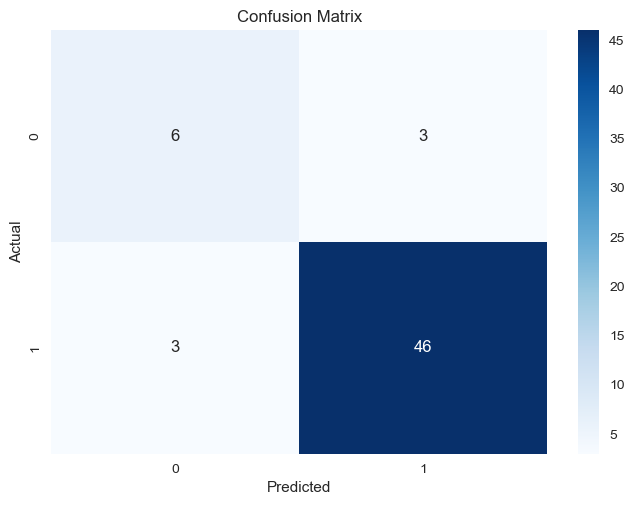

In [117]:
# Run model
print("Model Results for Finished Loans:")
run_logmodel(finloan_cus_data)

Model Results for Unfinished Loans:
Accuracy: 0.9814814814814815
Precision: 0.98989898989899
F1 Score: 0.98989898989899
Recall: 0.98989898989899
AUC-ROC Score: 0.9393939393939393
Gini: 0.8787878787878787


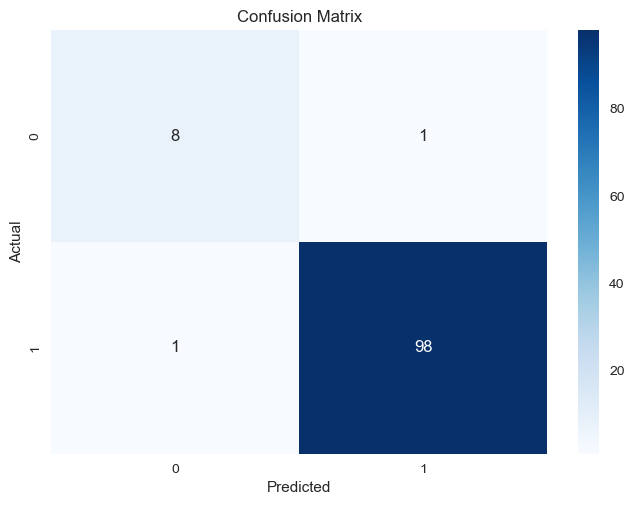

In [118]:
# Model results for Unfinished loans
print("Model Results for Unfinished Loans:")
run_logmodel(unfinloan_cus_data)

**Conclusion and Recommendation for Improvement**:
* Model for finished loans returns overall good performance.
* Model for unfinished loans recorded performance metrics of over 90%, with GINI indexes being 0.87. These numbers indicate that the models are overfitting the data and might not be able to generalize when new data is added, even through Ridge Regression regularization method has been implemented. => Suggestion: Collect and re-train the model with more data.